## Rennes Data Challenge 2023 

Mathis Derenne

---

### Results analysis

We provide a result analysis of the different model used.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
load_csv = lambda filename: pd.read_csv(Path('prediction') / filename, parse_dates=['date'], index_col='date').squeeze()

real_values = load_csv('real_value.csv')

pred_values = {
    'Baseline': load_csv('baseline_pred.csv'),
    'Prophet' : load_csv('prophet_pred.csv'),
    'RandomForest': load_csv('rfr_pred.csv'),
    'XGBoost': load_csv('xgb_pred.csv'),
    'SARIMAX': load_csv('sarimax_pred.csv'),
}

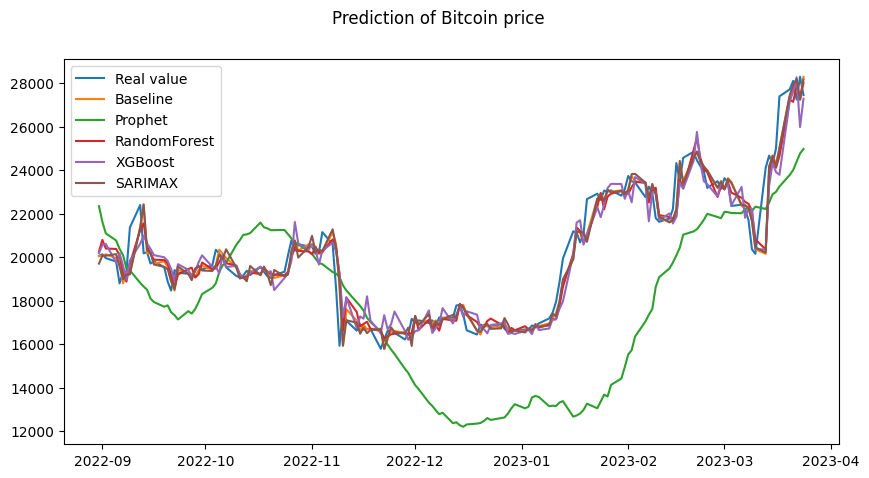

In [3]:
# Plot Bitcoin values predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(real_values, label = 'Real value')

for model_name, pred in pred_values.items():
    ax.plot(pred, label = model_name)

ax.legend()
fig.suptitle('Prediction of Bitcoin price');

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compute_score(real, pred):
    return {
        'mse': mean_squared_error(real, pred),
        'mae': mean_absolute_error(real, pred),
        'r2': r2_score(real, pred)
    }

metrics = [compute_score(real_values, pred) for pred in pred_values.values()]

pred_values_metrics = pd.DataFrame(metrics, index = pred_values.keys()).sort_values('r2', ascending=False)
pred_values_metrics

,mse,mae,r2
Baseline,5.544669e+05,472.178311,0.936237
SARIMAX,5.874406e+05,493.157023,0.932445
RandomForest,6.244410e+05,525.824925,0.928190
XGBoost,7.970886e+05,610.077793,0.908336
Prophet,1.460313e+07,2979.504099,-0.679334


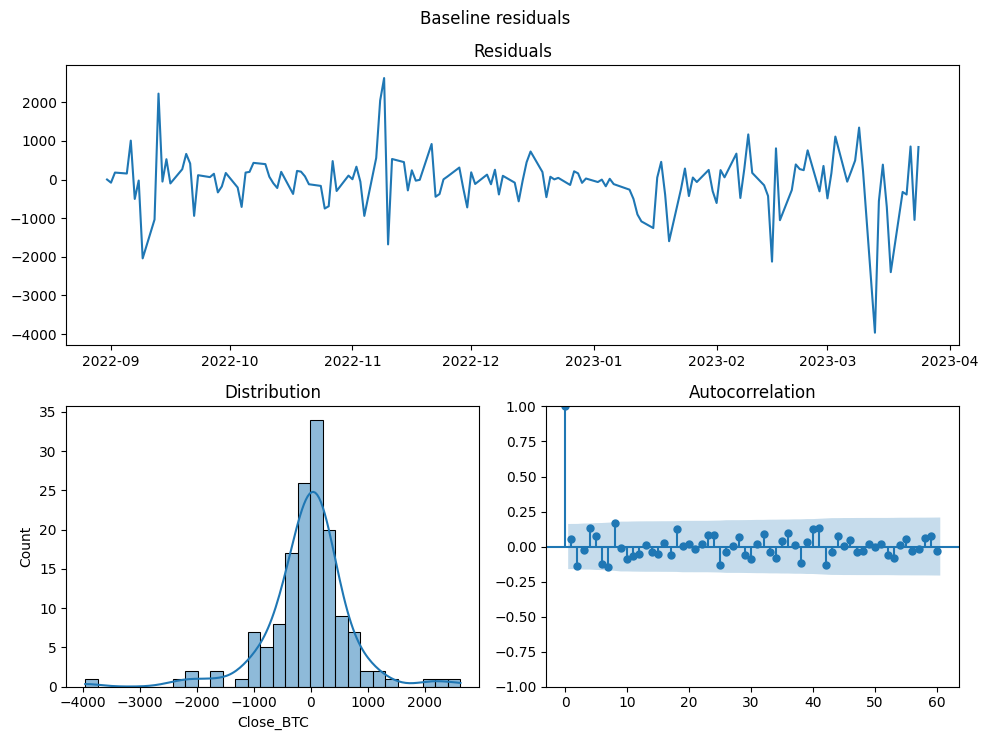

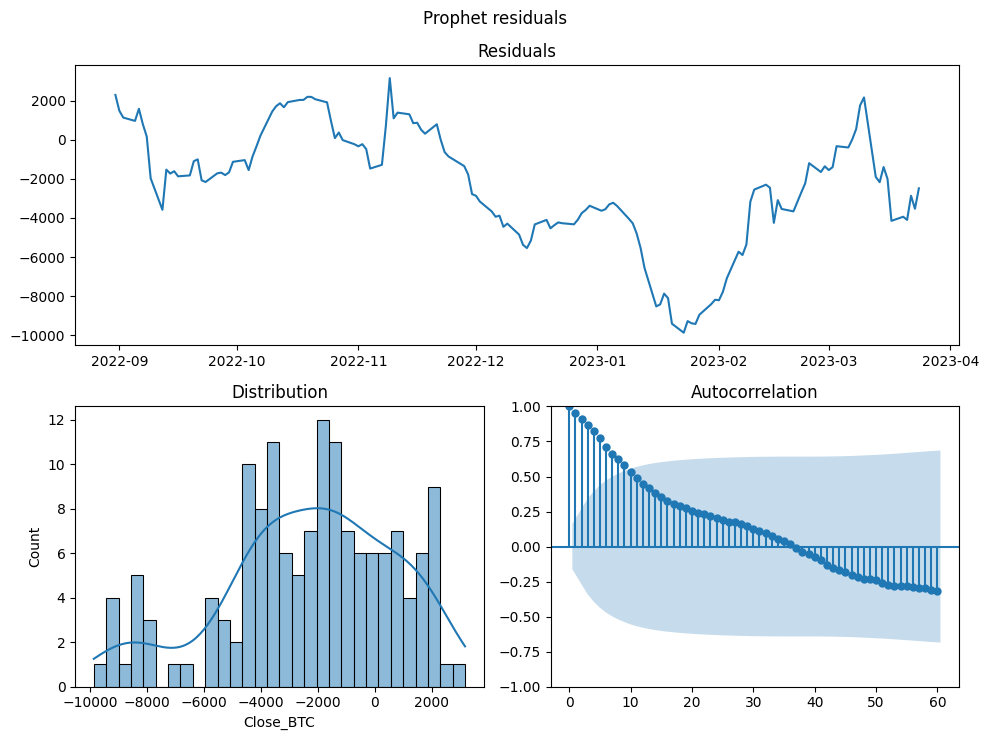

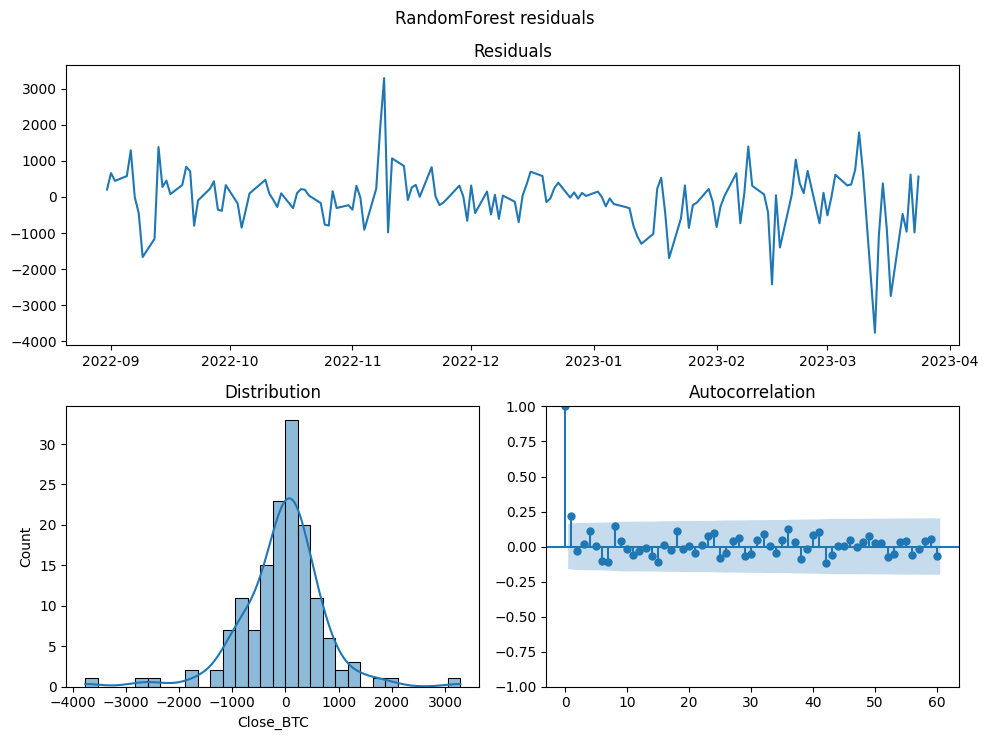

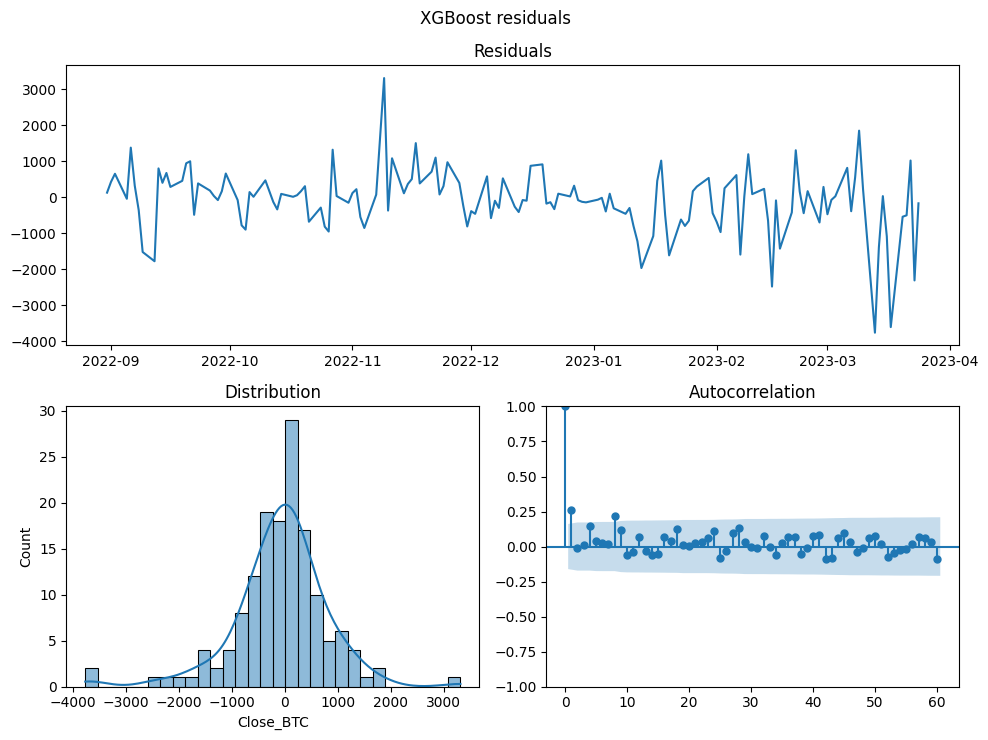

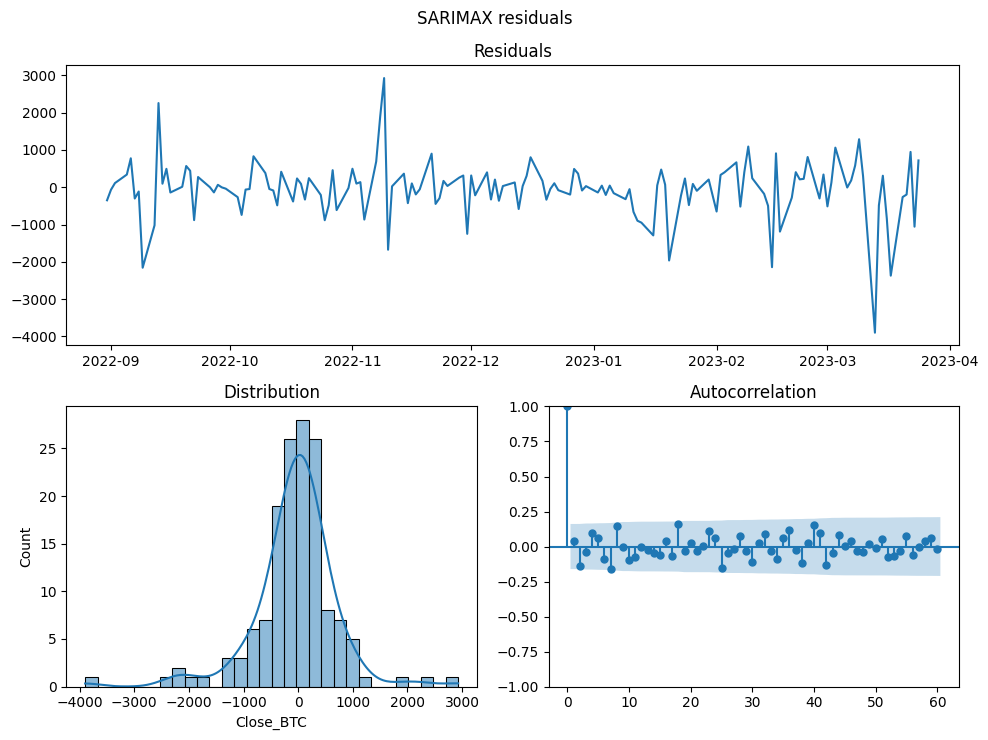

In [5]:
from skforecast.plot import plot_residuals

def plot_residual(real, pred, model):
    fig = plt.figure(figsize=(10, 7.5))
    plot_residuals(y_true = real, y_pred = pred, fig = fig)
    fig.suptitle(f'{model} residuals') 
    plt.tight_layout()
    plt.show()
    plt.close(fig);

# Plot residuals of Bitcoin values predictions
for model, pred in pred_values.items():
    plot_residual(real_values, pred, model)    

### Residuals analysis

Prophet : the prediction are consistently off by around -2000 units. Model does not seems to be able to use previous value to correct it's prediction.

RandomForest : autocorrelation of the residuals is very low and residuals are normally distributed around 0. These elements are good indicators of a good model.

### Bitcoin return analysis

Bitcoin returns is the metric of interests :
This series of notebook focused on predicting absolute Bitcoin values. However, the metric of interest that guide financial investment is predicted returns. 

By forecasting Bitcoin returns instead of Bitcoin values, we could improve the accuracy of our models.
This is true for several reasons : 
- Models aren't require anymore to understand scale of variation of Bitcoin values, but only the direction of the variation. This makes it a much simpler problem whereas naïve method used in Baseline would be far behind forecast predictions.
- Models such as SARIMAX relies on an hypothesis of stationarity which haven't been verified in EDA. By differentiating BTC values (either as (X_t - X_t-1) / X_t or as log(X_t) - log(X_t-1)) it ensures stationarity and helps models improve their accuracies..

In [6]:
def compute_return(series: pd.Series) -> pd.Series:
    return series.pct_change().shift(-1).iloc[:-1]

real_returns = compute_return(real_values)
pred_returns = { model: compute_return(pred) for model, pred in pred_values.items() }

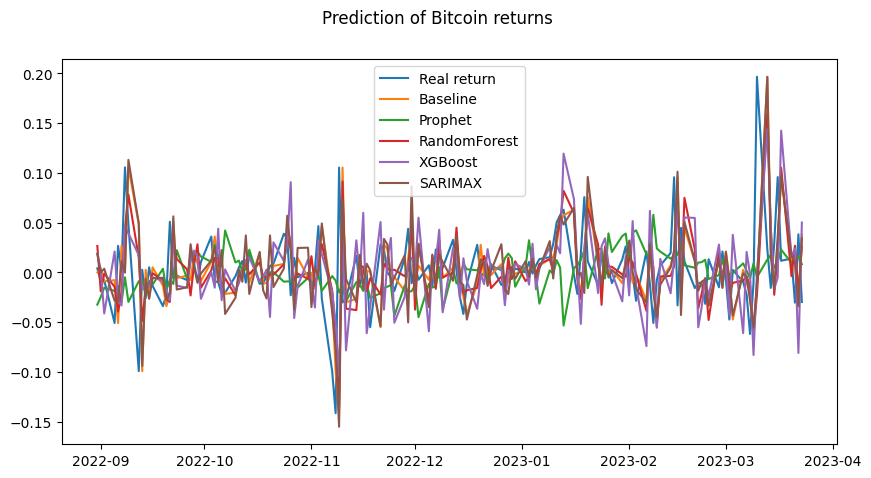

In [7]:
# Plot Bitcoin returns predictions
time_range = pd.TimedeltaIndex

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(real_returns, label = 'Real return')

for model_name, pred in pred_returns.items():
    ax.plot(pred, label = model_name)

ax.legend()
fig.suptitle('Prediction of Bitcoin returns');

In [8]:
metrics = [compute_score(real_returns, pred) for pred in pred_returns.values()]

pred_values_metrics = pd.DataFrame(metrics, index = pred_values.keys()).sort_values('r2', ascending=False)
pred_values_metrics

,mse,mae,r2
Prophet,0.001673,0.028126,-0.256215
RandomForest,0.002350,0.034136,-0.764423
Baseline,0.002544,0.033823,-0.909806
XGBoost,0.002678,0.038029,-1.010892
SARIMAX,0.002780,0.036748,-1.087637


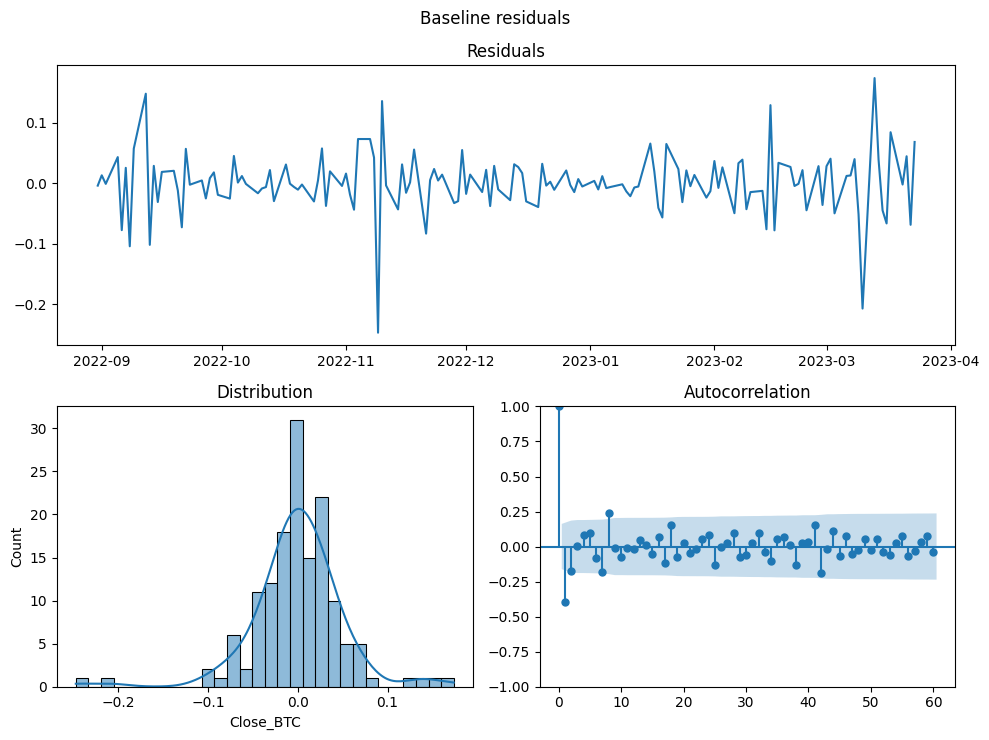

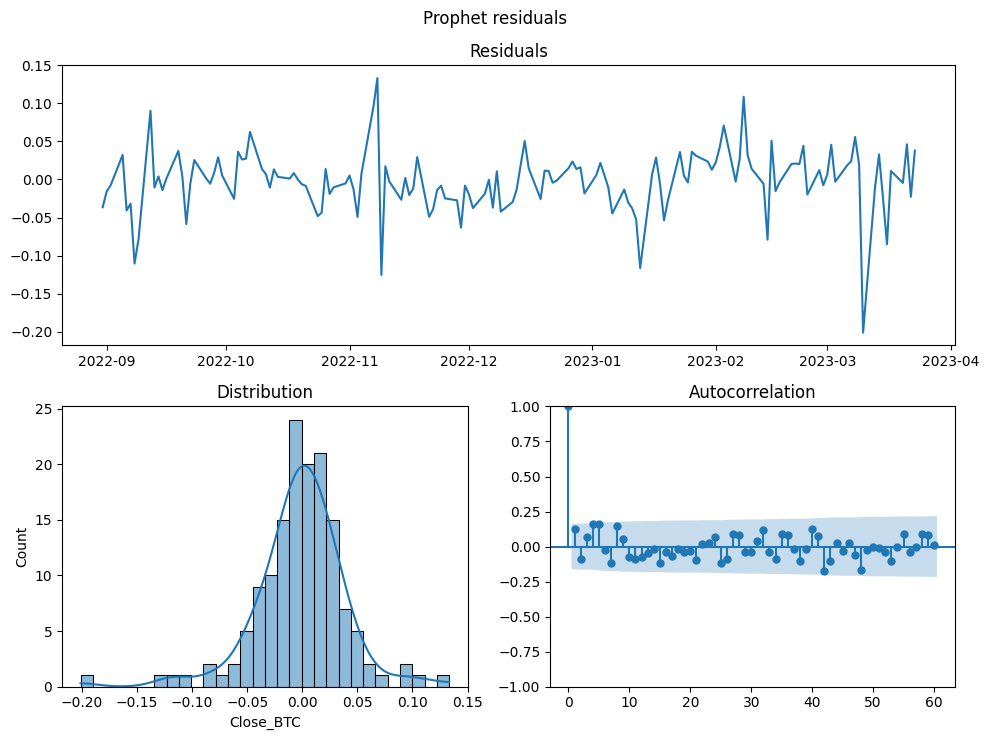

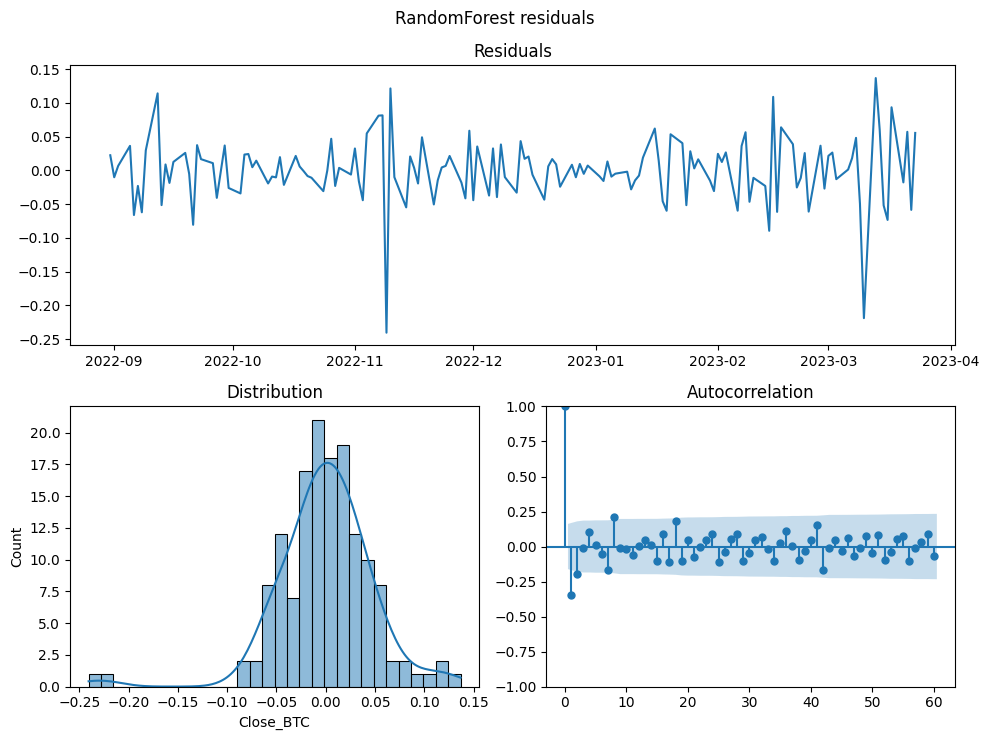

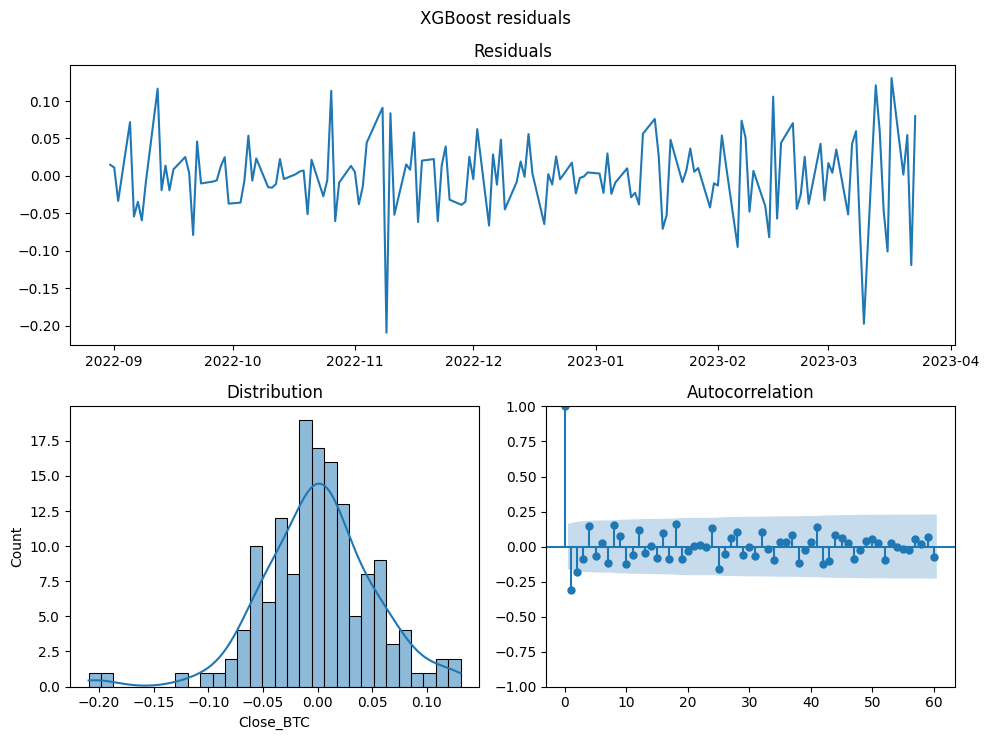

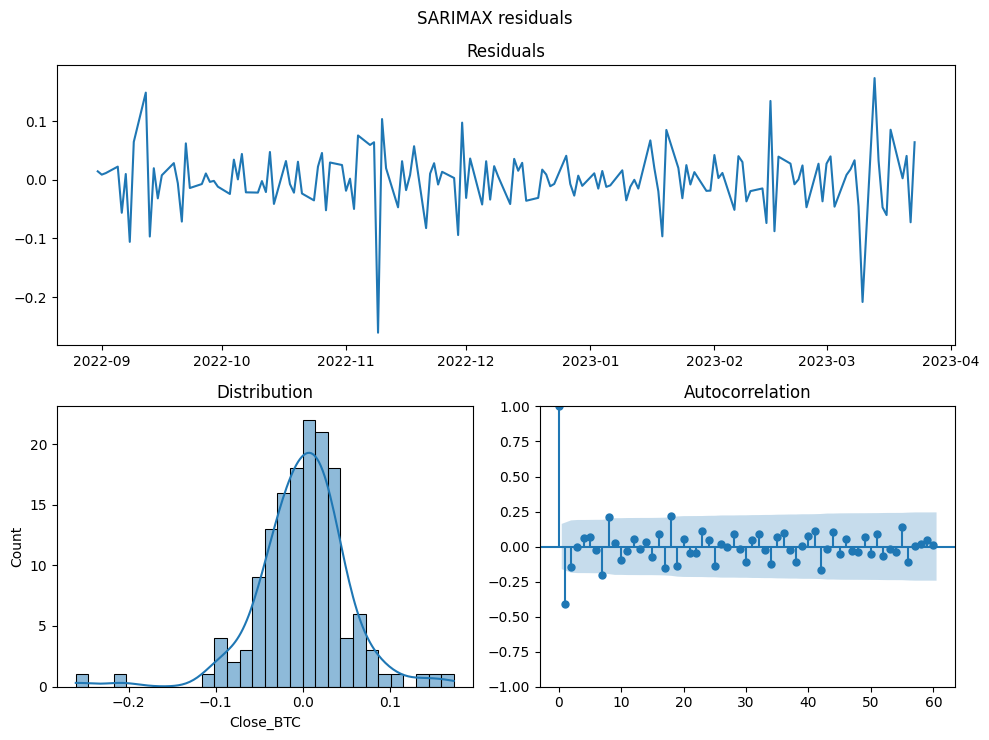

In [9]:
# Plot residuals of Bitcoin returns predictions
for model, pred in pred_returns.items():
    plot_residual(real_returns, pred, model)    

In [22]:
def compute_total_returns(real_returns: pd.Series, pred_returns: pd.Series) -> pd.Series:
    """
    Strategy : Invest when pred_returns is > 0 otherwise short your assets.
    Use real_returns to compute total returns starting from a base index of 1.
    """

    # Iterate over the real_returns and pred_returns
    total_returns = [1]
    for real_return, pred_return in zip(real_returns, pred_returns):
        if pred_return > 0:
            total_returns.append(total_returns[-1] * (1 + real_return))
        else:
            total_returns.append(total_returns[-1])
    
    # Ignore the starting value
    total_returns = total_returns[1:]

    return pd.Series(total_returns, index = real_returns.index)

def compute_buy_hold_returns(real_returns: pd.Series) -> pd.Series:
    """ Strategy : Buy and hold Bitcoin. """

    # Iterate over the real_returns
    total_returns = [1]
    for real_return in real_returns:
        total_returns.append(total_returns[-1] * (1 + real_return))
    
    # Ignore the starting value
    total_returns = total_returns[1:]

    return pd.Series(total_returns, index = real_returns.index)

real_total_returns = compute_total_returns(real_returns, real_returns)
buy_hold_total_returns = compute_buy_hold_returns(real_returns)
pred_total_returns = { model: compute_total_returns(real_returns, pred) for model, pred in pred_returns.items() }

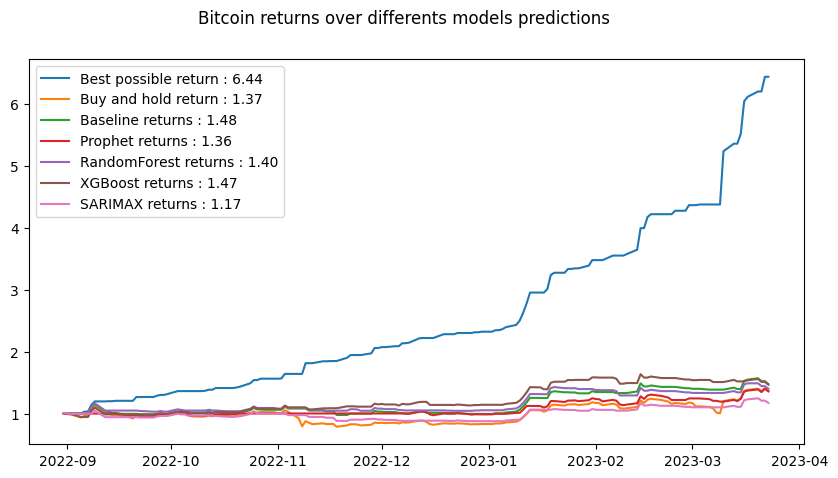

In [24]:
# Plot Bitcoin total returns predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(real_total_returns, label = f"Best possible return : {real_total_returns.iloc[-1]:.2f}")
ax.plot(buy_hold_total_returns, label = f"Buy and hold return : {buy_hold_total_returns.iloc[-1]:.2f}")
        
for model_name, pred in pred_total_returns.items():
    ax.plot(pred, label = f"{model_name} returns : {pred.iloc[-1]:.2f}")

ax.legend()
fig.suptitle('Bitcoin returns over differents models predictions');

### Possible improvements

2. Analysing results further : 

3. Implementing other models

4. Optimize hyperparameters

5. Improve pre-processing of data
- Adding features such as day of the year (transformed by cos/sin) for RandomForest and XGBoost could improve accuracy
- Trying to use SVD instead of PCA